# Oblique planar microscopy (OPM) simulations

### Background

Accurately simulating the three dimensional (3D) point spread function (PSF) of an oblique planar microscopy system requires accurate modeling of the transmitted pupil pattern [1-4]. This code presents a means for simulating the pupil pattern of the primary objective lens (O1) through the remote objectives (O2 and O3).
This work uses methodology developed in [5-6].

The numerical aperture (NA) of O1 is defined as:

$NA_{primary} = n_1sin(\alpha_{primary})$

where $n_1$ is the refractive index of the specimen. For an OPM system, the light sheet is delivered from O1 with a NA defined as:
    
$NA_{illumiunation} = n_1sin(\alpha_{illumination})$ 

Assuming that the illumination NA is at the edge of O1's pupil, then the central axis of the light sheet lies at:

$\gamma = \alpha_{primary} - \alpha_{illumination}$

At the remote focus, this requires O3 to be tilted relative to O2 by:
    
$\gamma_{tilt} = 90 - \gamma$

We can define the normal of O3 can as:
    
$\hat{\bf{n}} = sin(\gamma_{tilt})\hat{\bf{e_{x}}} + cos(\gamma_{tilt})\hat{\bf{e_{z}}}$

where we let $\hat{\bf{n}}$ be contained in the $xz$ plane. In this coordinate system, any ray exiting the light cone of O2 can be described by:
    
$\hat{\bf{k}} = sin(\theta)cos(\phi)\hat{\bf{e_{x}}} + sin(\theta)sin(\phi)\hat{\bf{e_{y}}} + cos(\theta)\hat{\bf{e_{z}}}$

where $\theta$ and $\phi$ are the polar and azimuthal angles.

The angle of incidence of these rays on O3 are given by:
    
$sin(\psi) = | \hat{\bf{k}} \times \hat{\bf{n}} |$

$cos(\psi) = | \hat{\bf{n}} \cdot \hat{\bf{k}} |$

The refracted angle, $\psi'$ can then be calculated from Snell's law as:

$n_2sin(\psi) = n_3sin(\psi')$
                       
where $n_2$ is the refractive index of O2 (typically air) and $n_3$ is the refractive index of O3 (air, water, or solid immersion). To optionally model reflections, the $s$ and $p$ polarization coefficients can then be calculated as:
                       
$R_s = |\frac{n_2cos(\psi) - n_3cos(\psi')}{n_2cos(\psi) + n_3cos(\psi')}|^2$
                       
$R_p = |\frac{n_2cos(\psi') - n_3cos(\psi)}{n_2cos(\psi') + n_3cos(\psi)}|^2$
                       
Where for unpolarized fluorescence, the transmittance is given by:
                       
$T = 0.5 \times (1 - R_s) + 0.5 \times (1 - R_p)$
                       
Finally, rays from O2 to O3 can be clipped based on the acceptance NA of O3:
                       
$\psi' > sin^{-1}(\frac{NA_{O3}}{n_3})$
                       
If O2 has a smaller NA (in air) than O1, then additional clipping is applied based on O2's pupil:

$\theta > sin^{-1}(\frac{NA_{O2}}{n_2})$
                       
Finally, an optional weighting can be applied based on the transmittance $T$. This yields the final pupil function $P(k_x,k_y)$.
                       
To obtained the 3D PSF, $P$ can be propagted to the sample space with Fourier transforms and an axial propagator $k_z$:
                       
$PSF(x,y,z) = \int{\int{P(k_x,k_y)e^{2\pi i(k_xx+k_yy)}e^{2\pi ik_z(k_x,k_y)z}}}dk_xdk_y$
                       
where $k_z = \sqrt{\frac{n_0}{\lambda} - (k_x^2 + k_y^2)}$

### References

[1] Botcherby, E.J., et al., An optical technique for remote focusing in microscopy. Optics Communications, 2008. 281(4)

[2] Dunsby, C., Optically sectioned imaging by oblique plane microscopy. Optics Express, 2008. 16(25)

[3] Yang, B., et al., Epi-illumination SPIM for volumetric imaging with high spatial-temporal resolution. Nature Methods, 2019. 16(6)

[4] Millett-Sikking, A., et al. [High NA single-objective light-sheet](https://andrewgyork.github.io/high_na_single_objective_lightsheet/index.html). 2019.

[5] McGorty, R., D. Xie, and B. Huang, High-NA open-top selective-plane illumination microscopy for biological imaging. Optics Express, 2017. 25(15)

[6] Hanser, B.M., et al., Phase-retrieved pupil functions in wide-field fluorescence
microscopy. Journal of Microscopy, 2004. 216

In [66]:
import numpy as np
import cmath
%matplotlib notebook
import matplotlib.pyplot as plt
import skimage.transform as transform
import scipy.signal as signal
from scipy import ndimage

In [67]:
# ## INPUTS ##

N = 256 # numerical grid size
dx = 0.2 # pixel size at sample plane (um)
NA_primary = 0.450*1.56 # primary objective lens NA
NA_secondary = 0.450 # secondary objective lens NA
NA_remote = 0.95 # remote objective lens NA
NA_illumination = 0.10*1.56 # illumination light sheet NA
RI0 = 1.56 # RI at sample
RI1 = 1.00 # RI at O2
RI2 = 1.00 # RI at O3
wavelength = 0.638 # wavelength (um)
gamma = np.pi/4.0 # remote tilt angle (rad)
apodization_factor = 2 # gaussian illumination apodization

<IPython.core.display.Javascript object>


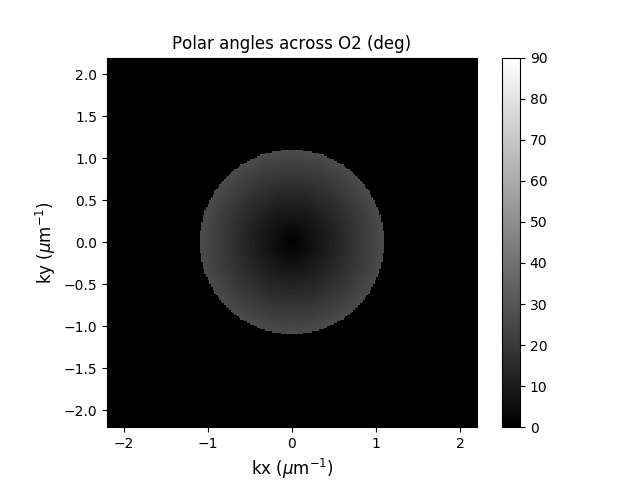

In [68]:
## CALCULATE ADDITIONAL VARIABLES ##

# primary NA in air
NA_primary_air = NA_primary / RI0

# secondary NA in air
NA_secondary_air = NA_secondary / RI1

# remote NA in air
NA_remote_air = NA_remote / RI2

# illumination NA in air
NA_illumination_air = NA_illumination / RI0

# primary optical angle (rad)
alpha_primary = np.arcsin(NA_primary_air)

# secondary optical angle (rad)
alpha_secondary = np.arcsin(NA_secondary_air)

# remote optical angle (rad)
alpha_remote = np.arcsin(NA_remote_air)

# illumination optical angle (rad)
alpha_illumination = np.arcsin(NA_illumination_air) 

## SETUP NUMERICAL GRIDS ##
[x_pxl,y_pxl] = np.meshgrid(np.arange(-N/2, N/2+1) , np.arange(-N/2, N/2+1)) # xy
dk = 1.0/(N*dx)  # frequency space sampling
kx = dk*x_pxl # kx
ky = dk*y_pxl # ky
kr = np.sqrt(kx**2+ky**2) # kr

kz = np.sqrt((RI0/wavelength)**2 - np.square(kr), dtype = complex) # kz (axial operator)

## CLIP FUNCTIONS BASED ON PRIMARY NA
k_max = NA_primary/wavelength
krr = kr/k_max # scaled kr

krr[krr>1] = 0.0
kx[krr>1] = 0.0
ky[krr>1] = 0.0

## GET ANGLE OF RAYS ACROSS PUPIL OF O2
theta = krr*np.arcsin(NA_primary_air)
phi = np.arctan2(ky,kx)

## CLIP FUNCTIONS BASED ON SECONDARY NA
krr[theta>alpha_secondary] = 0.0
kx[theta>alpha_secondary] = 0.0
ky[theta>alpha_secondary] = 0.0
theta[theta>alpha_secondary] = 0.0
phi[theta>alpha_secondary] = 0.0

plt.subplots()
plt.imshow(theta*180/np.pi, extent = [-dk*N/2.0, dk*N/2.0, -dk*N/2.0, dk*N/2.0], vmin = 0, vmax = 90)
plt.title('Polar angles across O2 (deg)', fontsize = 12)
plt.xlabel(r'kx ($\mu$m$^{-1}$)', fontsize = 12)
plt.ylabel(r'ky ($\mu$m$^{-1}$)', fontsize = 12)
plt.xlim([-2*k_max,2*k_max])
plt.ylim([-2*k_max,2*k_max])
plt.colorbar()

<IPython.core.display.Javascript object>


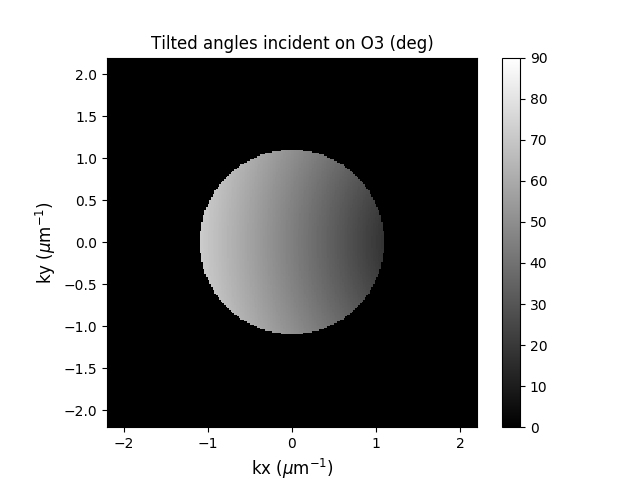

In [69]:
## CALCULATE VECTORS OF TILTED O3
beta_prime = np.zeros((N+1,N+1)); # matrix of tilted pupil function angles
transmittance = np.zeros((N+1,N+1)); # matrix of fresnel coefficients
n_v = np.array([np.sin(gamma), 0.0, np.cos(gamma)]); # normal of tilted plane

for i in range(0, len(theta)):
    for j in range(0, len(phi)):
        if kr[i, j]/k_max>1.0:
            beta_prime[i, j] = 0.0;
            transmittance[i, j] = 0.0;
        else:
            # TILTED VECTORS
            theta_i=theta[i, j];
            phi_j=phi[i, j];       
            k_v=np.array([np.sin(theta_i)*np.cos(phi_j), np.sin(theta_i)*np.sin(phi_j), np.cos(theta_i)]);      
            
            # GET REFRACTED ANGLES AT REMOTE FOCUS
            sin_beta = np.linalg.norm(np.cross(k_v,n_v));
            cos_beta = np.linalg.norm(np.dot(k_v,n_v));
            beta_prime[i, j] = np.arcsin(RI1*sin_beta/RI2); # refracted angles between RI1/RI2 at O3

## CLIP TILTED PUPIL BY REMOTE NA
beta_prime[beta_prime>alpha_remote] = 0.0;

plt.subplots()
plt.imshow(beta_prime*180/np.pi, extent = [-dk*N/2.0, dk*N/2.0, -dk*N/2.0, dk*N/2.0], vmin = 0, vmax = 90)
plt.title('Tilted angles incident on O3 (deg)', fontsize = 12)
plt.xlabel(r'kx ($\mu$m$^{-1}$)', fontsize = 12)
plt.ylabel(r'ky ($\mu$m$^{-1}$)', fontsize = 12)
plt.xlim([-2*k_max,2*k_max])
plt.ylim([-2*k_max,2*k_max])
plt.colorbar()

<IPython.core.display.Javascript object>


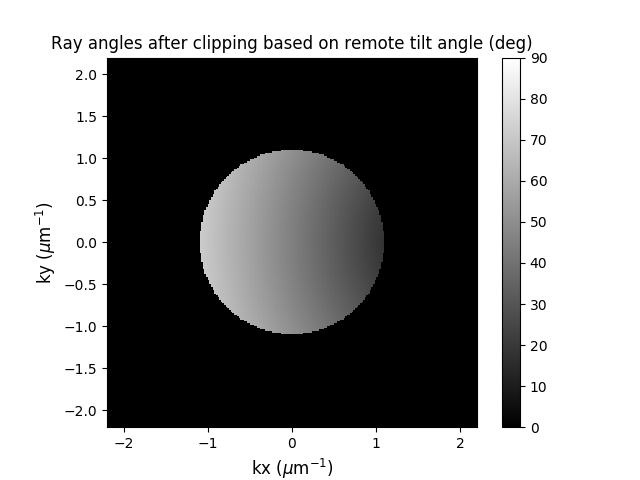

In [70]:
## CLIP RAYS WHICH ARE NOT CONVERGING TOWARDS O3 - PROBABLY MORE EFFICIENCY WAY TO DO THIS
L = theta[int(N/2)+1, :] - (np.pi/2.0 - gamma); # ADJUST INITIAL RAYS BY TILT ANGLE
ind = np.where(L>0.0)[0]; # GRAB ONLY FIRST HALF OF INDICES
ind = ind[ind<int(N/2)+1]
beta_prime[:, ind] = 0.0;

plt.subplots()
plt.imshow(beta_prime*180/np.pi, extent = [-dk*N/2.0, dk*N/2.0, -dk*N/2.0, dk*N/2.0], vmin = 0, vmax = 90)
plt.title('Ray angles after clipping based on remote tilt angle (deg)', fontsize = 12)
plt.xlabel(r'kx ($\mu$m$^{-1}$)', fontsize = 12)
plt.ylabel(r'ky ($\mu$m$^{-1}$)', fontsize = 12)
plt.xlim([-2*k_max,2*k_max])
plt.ylim([-2*k_max,2*k_max])
plt.colorbar()

<IPython.core.display.Javascript object>


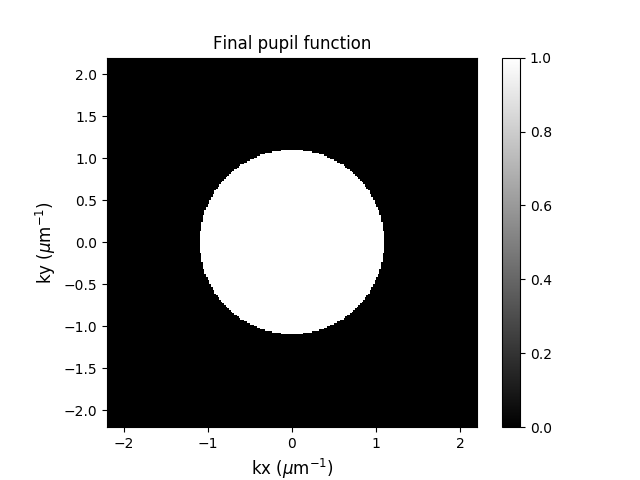

In [71]:
## GENERATE FINAL PUPIL FUNCTION
PF = np.zeros((N+1,N+1));
PF[beta_prime!=0.0] = 1.0;

plt.subplots()
plt.imshow(PF, extent = [-dk*N/2.0, dk*N/2.0, -dk*N/2.0, dk*N/2.0], vmin = 0, vmax = 1)
plt.title('Final pupil function', fontsize = 12)
plt.xlabel(r'kx ($\mu$m$^{-1}$)', fontsize = 12)
plt.ylabel(r'ky ($\mu$m$^{-1}$)', fontsize = 12)
plt.xlim([-2*k_max,2*k_max])
plt.ylim([-2*k_max,2*k_max])
plt.colorbar()
plt.gray()

# NORMALIZE PUPIL RELATIVE TO IDEAL PUPIL FILLING
fill_factor = len(np.where(PF>0.0)[0])/len(np.where(kr/k_max<=1.0)[0]);
PF = PF/np.sum(PF)*fill_factor

In [72]:
# CALCULATE COLLECTION PSF
zs = np.arange(-dx*N/2.0, dx*N/2.0, dx);
PSFc = np.zeros((N+1, N+1, N+1), dtype = complex);
for i in range(0, len(zs)):
    PSFc[:,:,i] = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(np.exp(2*np.pi*1j*kz*zs[i])*PF)));

PSFc = np.absolute(PSFc)**2

In [73]:
# CALCULATE ILLUMINATION PSF
k_max = NA_illumination/wavelength
krr = kr/k_max # scaled kr

PFi = np.exp(-(kr/(1.0/np.sqrt(apodization_factor)*k_max))**2)
PFi[krr>1.0] = 0.0 # outer clipping at 1/e^2
# PFi[krr<0.9] = 0.0 # outer clipping at 1/e^2
PFi = PFi/np.max(PFi)

zs = np.arange(-dx*N/2.0, dx*N/2.0, dx);
PSFi = np.zeros((N+1, N+1, N+1), dtype = complex);
for i in range(0, len(zs)):
    PSFi[:,:,i] = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(np.exp(2*np.pi*1j*kz*zs[i])*PFi)));

PSFi = np.absolute(PSFi)**2;
    
for i in range(0, PSFi.shape[0]):
    PSFi[i,:,:] = transform.rotate(PSFi[i,:,:], (np.pi/2.0-gamma)*180.0/np.pi)

<IPython.core.display.Javascript object>


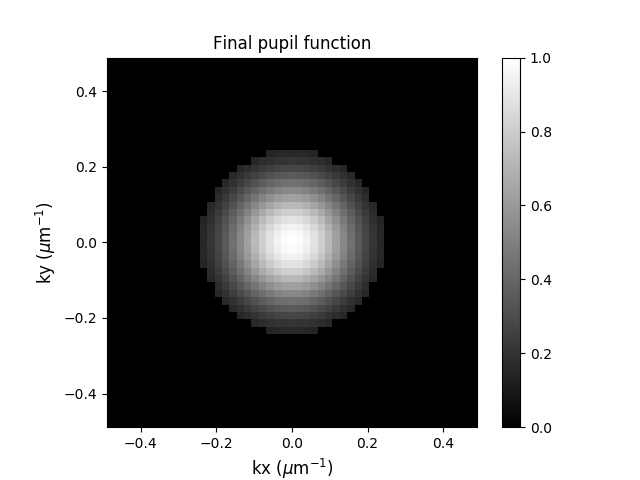

In [74]:
# ILLUMINATION PUPIL

plt.subplots()
plt.imshow(PFi, extent = [-dk*N/2.0, dk*N/2.0, -dk*N/2.0, dk*N/2.0], vmin = 0, vmax = 1)
plt.title('Final pupil function', fontsize = 12)
plt.xlabel(r'kx ($\mu$m$^{-1}$)', fontsize = 12)
plt.ylabel(r'ky ($\mu$m$^{-1}$)', fontsize = 12)
plt.xlim([-2*k_max,2*k_max])
plt.ylim([-2*k_max,2*k_max])
plt.colorbar()
plt.gray()

In [75]:
# CALCULATE TOTAL PSF
    
PSFtot = PSFc*PSFi
PSFtot = PSFtot/np.max(PSFtot)

<IPython.core.display.Javascript object>


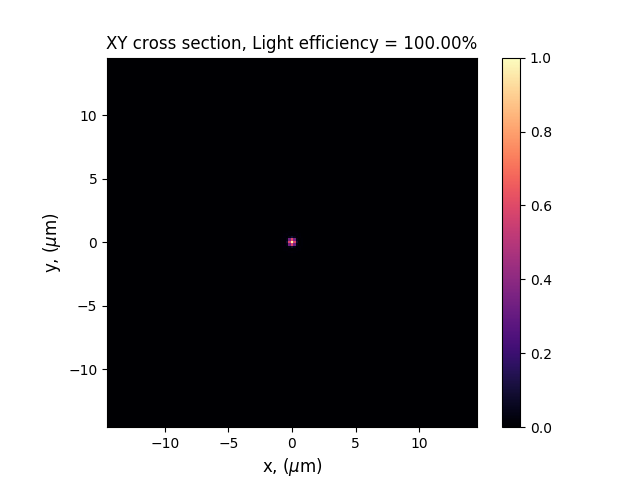

In [76]:
plt.subplots()
plt.imshow(np.transpose(PSFtot[:,:,int(N/2)+1]), extent = [-dx*N/2.0, dx*N/2.0, -dx*N/2.0, dx*N/2.0], vmin = 0, vmax = 1, cmap = 'magma')
plt.colorbar()
plt.xlabel(r'x, ($\mu$m)', fontsize = 12)
plt.ylabel(r'y, ($\mu$m)', fontsize = 12)
plt.xlim([-wavelength/NA_primary*16,wavelength/NA_primary*16])
plt.ylim([-wavelength/NA_primary*16,wavelength/NA_primary*16])
plt.title('XY cross section, Light efficiency = ' + "{:.2f}".format(fill_factor*100) + '%')

<IPython.core.display.Javascript object>


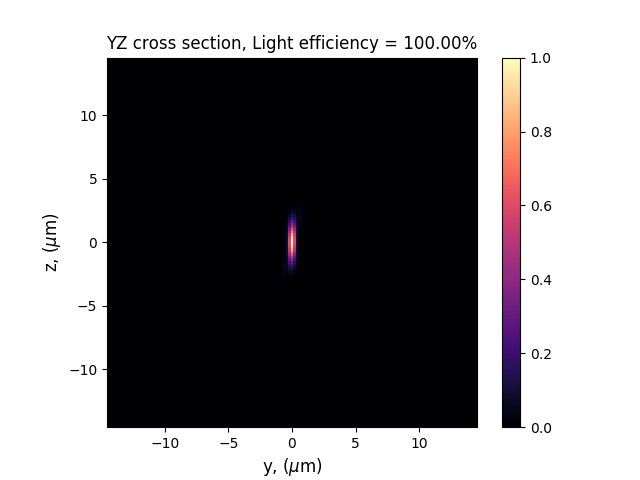

In [77]:
plt.subplots()
plt.imshow(np.transpose(PSFtot[int(N/2),:,:]), extent = [-dx*N/2.0, dx*N/2.0, -dx*N/2.0, dx*N/2.0], vmin = 0, vmax = 1, cmap = 'magma')
plt.colorbar()
plt.xlabel(r'y, ($\mu$m)', fontsize = 12)
plt.ylabel(r'z, ($\mu$m)', fontsize = 12)
plt.xlim([-wavelength/NA_primary*16,wavelength/NA_primary*16])
plt.ylim([-wavelength/NA_primary*16,wavelength/NA_primary*16])
plt.title('YZ cross section, Light efficiency = ' + "{:.2f}".format(fill_factor*100) + '%')

<IPython.core.display.Javascript object>


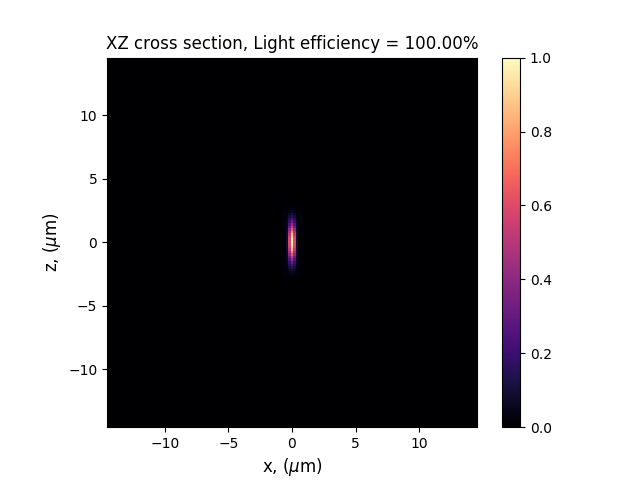

In [78]:
plt.subplots()
plt.imshow(np.transpose(PSFtot[:,int(N/2),:]), extent = [-dx*N/2.0, dx*N/2.0, -dx*N/2.0, dx*N/2.0], vmin = 0, vmax = 1, cmap = 'magma')
plt.colorbar()
plt.xlabel(r'x, ($\mu$m)', fontsize = 12)
plt.ylabel(r'z, ($\mu$m)', fontsize = 12)
plt.xlim([-wavelength/NA_primary*16,wavelength/NA_primary*16])
plt.ylim([-wavelength/NA_primary*16,wavelength/NA_primary*16])
plt.title('XZ cross section, Light efficiency = ' + "{:.2f}".format(fill_factor*100) + '%')